# Analog bit project walkthrough

In [1]:
# imports
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
try:
    from tueplots import bundles
    plt.rcParams.update(bundles.neurips2022())
except ModuleNotFoundError:
    pass
%load_ext autoreload
%autoreload 2

2023-05-15 09:47:07.789324: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## How to generate the data

Several ways to create data, only one generator is implemented, the ```flags``` dataset

In [2]:
# imports
from utils.data_gen import get_data_gen

In [3]:
generate_train_data = get_data_gen('flags', (3,8), 100, rgb=True)
generate_test_data = get_data_gen('flags', (3,8), 20, rgb=True)

In [4]:
train_data = generate_train_data()
test_data = generate_test_data()

In [5]:
train_data.shape

(100, 3, 8, 3)

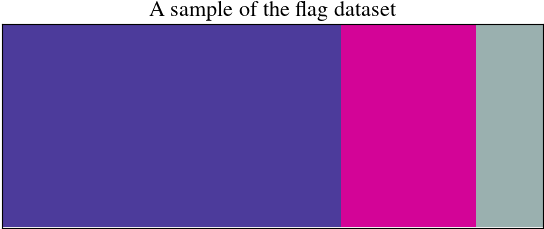

In [10]:
from utils.display import show_flag
show_flag(train_data[2])

## Fake predictor task

To test our model, we will create a false ground truth

In [8]:
# Fake ground truth
def invert_color(data : np.ndarray):
    """Invert the color of RGB channels"""
    return 255 - data
train_ground_truth = invert_color(train_data)
test_ground_truth = invert_color(test_data)

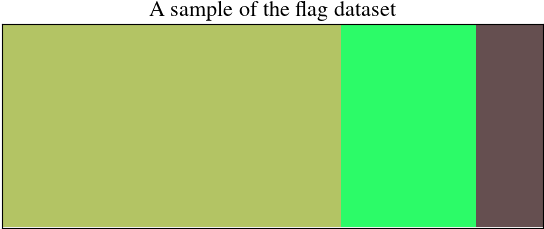

In [11]:
show_flag(train_ground_truth[2])

## Convert to bits

In [20]:
from utils.bit_encoding import rgb2bit, get_x_channels

b_type = 'uint8'
channels = get_x_channels(b_type)
kwargs = {'b_type': b_type, 'b_scale': 1.0, 'x_channels': channels}
train_data_bits = rgb2bit(images=train_data, **kwargs)
gt_train_data_bits = rgb2bit(images=train_ground_truth, **kwargs)
test_data_bits = rgb2bit(images=test_data, **kwargs)
gt_test_data_bits = rgb2bit(images=test_ground_truth, **kwargs)

In [21]:
print("(Number of samples, height, width, analogbits) =", train_data_bits.shape)

(Number of samples, height, width, analogbits) = (100, 3, 8, 24)


## Define noise and denoiser step

In [22]:
from models.analog_bits import get_model
input_shape = train_data_bits.shape[1:]
model = get_model(input_shape=input_shape)

In [23]:
model(train_data_bits).shape

TensorShape([100, 3, 8, 24])

In [24]:
train_dataset_bits = tf.data.Dataset.from_tensor_slices(train_data_bits)
gt_train_dataset_bits = tf.data.Dataset.from_tensor_slices(gt_train_data_bits)
test_dataset_bits = tf.data.Dataset.from_tensor_slices(test_data_bits)
gt_test_datasets_bits = tf.data.Dataset.from_tensor_slices(gt_test_data_bits)

In [25]:
loss_fn = tf.keras.losses.MeanAbsoluteError()
def loss(model : tf.keras.Model, x, y, training):
    y_ = model(x, training=training)

    return loss_fn(y, y_)

In [29]:
features = next(iter(train_dataset_bits.batch(32)))
ground_truth = next(iter(gt_train_dataset_bits.batch(32)))
l = loss(model, features, ground_truth, training=False)
print("Loss test: {}".format(l))

(32, 3, 8, 24)
Loss test: 1.0150456428527832


2023-05-15 10:04:24.171377: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [100,3,8,24]
	 [[{{node Placeholder/_0}}]]
2023-05-15 10:04:24.178611: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [100,3,8,24]
	 [[{{node Placeholder/_0}}]]


In [30]:
def grad(model, inputs, targets):
  with tf.GradientTape() as tape:
    loss_value = loss(model, inputs, targets, training=True)
  return loss_value, tape.gradient(loss_value, model.trainable_variables)

In [31]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

In [36]:
## Note: Rerunning this cell uses the same model parameters

# Keep results for plotting
train_loss_results = []
train_accuracy_results = []

num_epochs = 201

ds_train_batch = train_dataset_bits.batch(32)
ds_train_batch_gt = gt_train_dataset_bits.batch(32)

for epoch in range(num_epochs):
  epoch_loss_avg = tf.keras.metrics.Mean()
  # epoch_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()

  # Training loop - using batches of 32
  for x, y in zip(ds_train_batch,ds_train_batch_gt):
    # Optimize the model
    loss_value, grads = grad(model, x, y)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    # Track progress
    epoch_loss_avg.update_state(loss_value)  # Add current batch loss
    # Compare predicted label to actual label
    # training=True is needed only if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
    # epoch_accuracy.update_state(y, model(x, training=True))

  # End epoch
  train_loss_results.append(epoch_loss_avg.result())
  # train_accuracy_results.append(epoch_accuracy.result())

  if epoch % 50 == 0:
    print("Epoch {:03d}: Loss: {:.3f}".format(epoch, epoch_loss_avg.result()))


2023-05-15 10:34:37.339988: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [100,3,8,24]
	 [[{{node Placeholder/_0}}]]
2023-05-15 10:34:37.343545: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [100,3,8,24]
	 [[{{node Placeholder/_0}}]]


Epoch 000: Loss: 0.983
Epoch 050: Loss: 0.556
Epoch 100: Loss: 0.513
Epoch 150: Loss: 0.490
Epoch 200: Loss: 0.481


In [38]:
feature_test = model(features, training=False)

In [52]:
from utils.bit_encoding import bit2rgb
feature_test_int = bit2rgb(feature_test, b_type=b_type)
feature_int = bit2rgb(features, b_type=b_type)

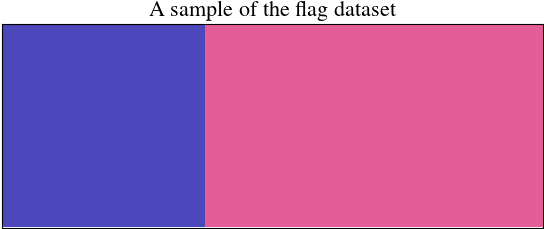

In [53]:
# Model output
show_flag(feature_test_int[0])

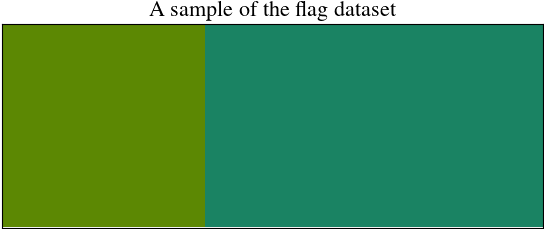

In [54]:
# Original data
show_flag(feature_int[0])

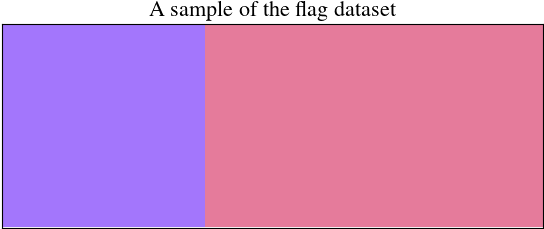

In [55]:
# "True" inverted color
show_flag(1.0 - feature_int[0])